# Control the robot_plotter

## Import all the libraries
* The `serial` library is used to communicate.
* The `sleep` command from the `time` library is used to add delays in the execution.
* The `pandas` library is used to organize the coordinates and angle data.
* The `numpy` library is used to perform the necessary calculations.
* The `matplotlib` library is used to plot the coordinates to confirm if they are the correct ones.

In [61]:
import serial
from time import sleep
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Dimensions of the arms
The dimensions of the arms of the robot are set here. The exact value must be known for calculations of forward and inverse kinematics.


In [62]:
l2 = 100 #mm
d = 80   #mm
l1 = 60  #mm

## Forward Kinematics
These are the equations that describe how the joint coordinates ($q_1 , q_2$) affect the end effector location ($x , y$).

In [63]:
def forward_kinematics(row):
    q1, q2 = row[['q1', 'q2']]
    q1, q2 = np.deg2rad([q1, q2])
    
    A = l1*np.array([np.cos(q1), np.sin(q1)])
    B = np.array([d+l1*np.cos(q2), l1*np.sin(q2)])
    D = B-A
    
    psi = np.arctan2(D[1], D[0])
    h = np.linalg.norm(D)
    del1 = np.arccos(h/(2*l2))
    phi1 = del1+psi
    C = A+l2*np.array([np.cos(phi1), np.sin(phi1)])
    return C

## Inverse Kinematics
These are the equations that calculate the joint coordinates ($q_1 , q_2$) based on the desired end effector location ($x , y$).

In [64]:
def inverse_kinematics(row):
    x, y = row[['x','y']]
    C = np.sqrt(x**2+y**2)
    e = np.sqrt((d-x)**2+y**2)
    q1 = np.arctan2(y,x)+np.arccos((l1**2+C**2-l2**2)/(2*l1*C))
    q2 = np.pi-np.arctan2(y,d-x)-np.arccos((l1**2+e**2-l2**2)/(2*l1*e))
    return np.rad2deg([q1, q2])

## Load the path
Here, we read the **gcode** file that contains the drawing. Based on the desired end effector locations, the joint coordinates are calculated using the `inverse_kinematics` function. The drawing can be offset and scaled as needed using the offset_drawing function

#### Offset drawing function

In [ ]:
def offset_drawing(gcode, x_offset=0, y_offset=0, scale=1):

    middle_x = np.mean([gcode['x'].min(), gcode['x'].max()])
    middle_y = np.mean([gcode['y'].min(), gcode['y'].max()])
    gcode['x'] -= middle_x
    gcode['y'] -= middle_y
    gcode['x'] = -gcode['x'] #Flip the drawing
    gcode['y'] = -gcode['y'] #Flip the drawing
    
    gcode['x'] += x_offset 
    gcode['y'] += y_offset

    gcode['x'] = gcode['x']*scale
    gcode['y'] = gcode['y']*scale
    return gcode

#### Parse the gcode file
Read and compute the IK for the gcode instructions. The joint coordinates are then converted back to the end effector coordinates for plotting. View the plot, and adjust the offsets and scale as needed.

(-9.50004839999999, 89.50004840000001, -5.375721290000005, 112.8901470900001)

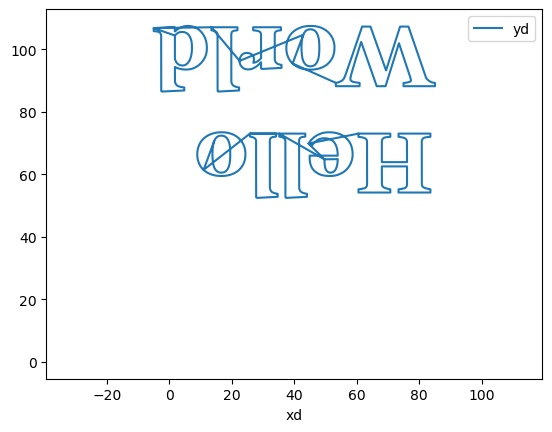

In [76]:
def parse_gcode_file(file):
    with open(file, 'r') as f:
        lines = f.readlines()
    gcode = pd.DataFrame(lines, columns=['gcode'])
    gcode.head()
    gcode['x'] = gcode['gcode'].str.extract(r'X(-?\d+\.\d+)')
    gcode['y'] = gcode['gcode'].str.extract(r'Y(-?\d+\.\d+)')
    gcode['P'] = gcode['gcode'].str.extract(r'P(\d+)')

    gcode['x'] = gcode['x'].astype(float)
    gcode['y'] = gcode['y'].astype(float)
    gcode['P'] = gcode['P'].astype(float)
    gcode = gcode.dropna(thresh=2)

    gcode = offset_drawing(gcode, x_offset=40, y_offset=80, scale=1)
    gcode[['q1', 'q2']] = gcode.apply(inverse_kinematics, axis=1, result_type='expand')
    gcode[['xd', 'yd']] = gcode.apply(forward_kinematics, axis=1, result_type='expand')
    return gcode

gcode = parse_gcode_file('drawings/name_new.gcode')
fig,ax = plt.subplots()
gcode.plot('xd', 'yd', marker=None, ax=ax)
plt.plot(0,0,'')
plt.axis('equal')

## Send joint coordinates to robot
Here, we send the calculated joint coordinates to the robot via the Serial port. Define the port name correctly.

**NOTE:** If you get an error opening the port, make sure the Serial Monitor is closed.

In [77]:
def send_command(command, ser):
    ser.reset_input_buffer()
    ser.write(command.encode())
    # what till we have data in the serial buffer, then check if it is the character G
    while ser.in_waiting == 0:
        if ser.read() == b'G':
            break

#### Send the drawing instructions
Start by moving the motors to their zero angle position. And then type H0 to home the robot. If fine adjustments are needed, enable the motors with the E1 command. And then adjust positions with X1Y2 commands. Once the motors are homed, send the H0 command.

In [79]:
with serial.Serial(port='COM14', baudrate=115200) as ser:
    while True:
        x = input("Write H0 after homing the motors to their 0 angle positions.")
        ser.write(x.encode())
        if x == 'H0':
            print("Homing complete.")
            break
    sleep(1)
    
    print("Setting the motor speed.")
    command = f'S500\n'
    ser.write(command.encode())
    [x_old, y_old] = [0,0]
    
    print("Sending joint coordinates to the robot.")
    for i, row in gcode.iterrows():
        if not row[['q1', 'q2']].isna().any():
            x, y = (row[['q1', 'q2']]).astype(float).round(3)
            if (x,y) != (x_old, y_old):
                [x_old, y_old] = [x, y]
                command = f'X{x:.3f}Y{y:.3f}\n'
                send_command(command, ser)

        p = row['P']
        if not np.isnan(p):
            if p == 1:
                print("Pen down.")
                command = f'P1'
                send_command(command, ser)
            else:
                print("Pen up.")
                command = f'P0'
                send_command(command, ser)


    print("Drawing complete.")
    
    x, y = [0,0]    
    command = f'X{x}Y{y}\n'
    send_command(command, ser)
    print("Returning to the home position.")
    ser.write('E0'.encode())

Homing complete.
Setting the motor speed.
Sending joint coordinates to the robot.
Pen up.
Pen down.
Pen up.
Pen down.
Pen up.
Pen down.
Pen up.
Pen down.
Pen up.
Pen down.
Pen up.
Pen down.
Pen up.
Pen down.
Pen up.
Pen down.
Pen up.
Pen down.
Pen up.
Pen down.
Pen up.
Pen down.
Pen up.
Pen down.
Pen up.
Pen down.
Pen up.
Pen down.
Pen up.
Drawing complete.
Returning to the home position.
